# AutoJudge: Predicting Programming Problem Difficulty

## 1. Project Overview
The goal of this project is to build an automated system that predicts the difficulty of competitive programming problems based **solely on their textual description**.

We avoid Deep Learning (BERT/Transformers) and instead use **Advanced Feature Engineering** and **Classical Ensemble Learning** to achieve high accuracy.

### Objectives
1. **Classification**: Predict if a problem is *Easy*, *Medium*, or *Hard*.
2. **Regression**: Predict the exact numerical difficulty score (e.g., 1400, 2100).
3. **Constraint**: Use only Classical Machine Learning (No Neural Networks).

### Methodology
* **Expert Text Cleaning**: Normalizing mathematical constraints (e.g., $10^9 \to$ `heavy_constraint`).
* **Hybrid Features**: Combining **TF-IDF** (n-grams) with **Handcrafted Cognitive Features** (e.g., "Dynamic Programming" keywords, math symbol density).
* **Ensemble Modeling**: Using a **Voting Classifier** (Logistic Regression + Random Forest + SVM) to maximize performance.

In [1]:
# --- IMPORTS ---
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Tools
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error
from scipy.sparse import hstack, csr_matrix

# Try importing XGBoost
try:
    from xgboost import XGBClassifier, XGBRegressor
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

# Setup NLTK
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gaurav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gaurav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Gaurav\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# --- LOAD DATA ---
try:
    # Ensure 'problems_data.jsonl' is in the same directory
    df = pd.read_json('problems_data.jsonl', lines=True)
    print(f"Loaded {len(df)} problems successfully.")
except FileNotFoundError:
    print("ERROR: File 'problems_data.jsonl' not found. Please upload it.")

# Fill NaNs to prevent errors
df.fillna('', inplace=True)

# Preview data
print(f"Columns: {df.columns.tolist()}")
df.head()

Loaded 4112 problems successfully.
Columns: ['title', 'description', 'input_description', 'output_description', 'sample_io', 'problem_class', 'problem_score', 'url']


,title,description,input_description,output_description,sample_io,problem_class,problem_score,url
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,"[{'input': '7 10', 'output': '1 2 2 3 1 3 3 4 ...",hard,9.7,https://open.kattis.com/problems/uuu
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,"[{'input': '0 2 3 2 50 60 50 30 50 40', 'outpu...",hard,9.7,https://open.kattis.com/problems/husbygge
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,"[{'input': '', 'output': ''}]",hard,9.6,https://open.kattis.com/problems/marioorluigi
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,"[{'input': '4 3 3 C 2 C 1 C', 'output': 'GHOST...",hard,9.6,https://open.kattis.com/problems/thewireghost
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,"[{'input': '2 0 10 0 10 10', 'output': '14.14'...",hard,9.6,https://open.kattis.com/problems/barktree


## 2. Advanced Text Preprocessing
Standard text cleaning (removing all numbers and punctuation) destroys information in programming problems. For example, $N \le 10^5$ implies an $O(N \log N)$ solution, while $N \le 20$ implies Exponential time.

We use a custom **Expert Cleaning Pipeline**:
1.  **Constraint Normalization**: We convert numbers like $10^9$ or $10^5$ into a special token `heavy_constraint`. This tells the model, *"This problem requires optimization."*
2.  **Symbol Retention**: We strictly keep symbols like `%`, `<`, `>`, `^` which indicate modular arithmetic or bitwise operations.
3.  **Lemmatization**: "Optimizing" $\to$ "Optimize". This reduces vocabulary noise and helps TF-IDF work better on small datasets.

In [3]:
def expert_cleaning(text):
    if not isinstance(text, str): return ""

    # 1. Capture Constraints (The "Hard" Signal)
    # Regex matches 10^5 to 10^18
    text = re.sub(r'10\^\{?[5-9]\}?', ' heavy_constraint ', text)
    text = re.sub(r'10\^\{?1[0-8]\}?', ' heavy_constraint ', text)
    text = re.sub(r'\d+(\.\d+)?\s?seconds?', ' time_limit ', text)

    # 2. Clean & Tokenize
    text = text.lower()
    text = re.sub(r'<.*?>', '', text) # Remove HTML
    text = re.sub(r'http\S+', '', text) # Remove URLs

    # Keep specific math symbols useful for logic
    text = re.sub(r'[^a-z0-9\s\%\^\<\>\=\_]', ' ', text)

    tokens = text.split()

    # 3. Lemmatization (Normalize words)
    clean_tokens = [
        lemmatizer.lemmatize(word) for word in tokens
        if word not in stop_words
    ]
    return " ".join(clean_tokens)

# Combine all text fields into one context window
df['raw_text'] = (df['title'] + " " + df['description'] + " " +
                  df['input_description'] + " " + df['output_description'])

print("Applying Expert Cleaning (this may take ~20 seconds)...")
df['clean_text'] = df['raw_text'].apply(expert_cleaning)
print("Cleaning Complete.")

Applying Expert Cleaning (this may take ~20 seconds)...
Cleaning Complete.


## 3. Feature Engineering
We use a **Hybrid Feature Approach** to feed the classical models:

1.  **TF-IDF Vectors**: Captures n-grams (phrases) like *"shortest path"* or *"binary tree"*.
2.  **Handcrafted Keywords**: We count specific domain words (e.g., *dp, graph, geometry, brute force*) which correlate with difficulty.
3.  **Cognitive Rarity Score**: A custom metric that measures how "obscure" the vocabulary is. Rare words often imply a harder or more specific problem.

In [4]:
# A. TF-IDF (Unigrams + Bigrams)
tfidf = TfidfVectorizer(max_features=6000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['clean_text'])

# B. Handcrafted Domain Features
def get_features(text):
    # Hard Topics
    dp = len(re.findall(r'dynamic programming|optimal|maximize|minimize|subsequence', text))
    graph = len(re.findall(r'graph|vertex|edge|tree|ancestor|connected component', text))
    math = len(re.findall(r'modulo|prime|gcd|divisible|remainder', text))
    geo = len(re.findall(r'geometry|convex|polygon|angle', text))

    # Easy Indicators
    brute = len(re.findall(r'iterate|every possible|check all', text))

    # Structural
    length = len(text.split())
    math_symbols = len(re.findall(r'[\%\^\<\>\=]', text))

    return [dp, graph, math, geo, brute, length, math_symbols]

X_handcrafted = np.array(df['clean_text'].apply(get_features).tolist())

# C. Rarity Score (Inverse Document Frequency Sum)
word_freq = np.asarray(X_tfidf.sum(axis=0)).ravel()
rarity_weights = 1.0 / (word_freq + 1.0)
rarity_scores = np.array(X_tfidf.multiply(rarity_weights).sum(axis=1))

# Combine & Scale Dense Features
X_dense = np.column_stack((X_handcrafted, rarity_scores))
scaler = StandardScaler()
X_dense_scaled = scaler.fit_transform(X_dense)

# Final Feature Matrix (Sparse + Dense)
X_final = hstack([X_tfidf, csr_matrix(X_dense_scaled)])
print(f"Final Feature Matrix Shape: {X_final.shape}")

Final Feature Matrix Shape: (4112, 6008)


## 4. Model Selection & Training
To achieve State-of-the-Art (SOTA) results without Deep Learning, we use **Ensemble Methods**.

* **Classification**: We use a **Voting Classifier** that combines:
    * *Logistic Regression*: Captures linear relationships.
    * *Random Forest*: Captures complex, non-linear logic.
    * *SVM*: Finds optimal hyperplanes in high-dimensional space.
    * *XGBoost*: (If available) Boosting algorithm for precision.
* **Regression**: We use **Gradient Boosting Regressor**, which minimizes error iteratively.

In [5]:
#LABEL PREPARATION & NORMALIZATION
le = LabelEncoder()
y_class = le.fit_transform(df['problem_class']) # Easy=0, Hard=1...

# --- NEW: NORMALIZE SCORES TO 1-10 RANGE ---
raw_scores = df['problem_score'].values
min_s, max_s = raw_scores.min(), raw_scores.max()

print(f"Original Score Range: {min_s} - {max_s}")

if max_s > 10:
    print("Scaling target scores to 1-10 range...")
    # MinMax Scaling Formula: 1 + (x - min) * 9 / (max - min)
    y_score = 1 + (raw_scores - min_s) * 9 / (max_s - min_s)
else:
    print("Scores are already in small range. Using as is.")
    y_score = raw_scores

print(f"New Score Range: {y_score.min():.2f} - {y_score.max():.2f}")

# Split Data
X_train, X_test, y_c_train, y_c_test, y_s_train, y_s_test = train_test_split(
    X_final, y_class, y_score, test_size=0.2, random_state=42
)

Original Score Range: 1.1 - 9.7
Scores are already in small range. Using as is.
New Score Range: 1.10 - 9.70


In [6]:
# 5. MODEL COMPARISON

# --- CLASSIFICATION MODELS ---
classifiers = {
    "Logistic Regression": LogisticRegression(C=1.0, max_iter=2000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=150, max_depth=15, random_state=42),
    "SVM (Linear)": SVC(kernel='linear', C=1.0, probability=True),
}

if HAS_XGB:
    classifiers["XGBoost"] = XGBClassifier(n_estimators=150, learning_rate=0.1, max_depth=6, eval_metric='mlogloss')

print("\nTraining Classifiers...")
best_acc = 0
best_clf_name = ""
best_clf_model = None

for name, model in classifiers.items():
    print(f"Training {name}...")
    model.fit(X_train, y_c_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_c_test, preds)
    print(f"   -> Accuracy: {acc*100:.2f}%")

    if acc > best_acc:
        best_acc = acc
        best_clf_name = name
        best_clf_model = model

print(f"\nBest Classifier: {best_clf_name} ({best_acc*100:.2f}%)")

# Create Voting Classifier using the Best Model + RF + LogReg (Ensemble usually wins)
print("Building Final Voting Ensemble...")
final_clf = VotingClassifier(
    estimators=[
        ('best', best_clf_model),
        ('rf', classifiers['Random Forest']),
        ('lr', classifiers['Logistic Regression'])
    ],
    voting='soft'
)
final_clf.fit(X_train, y_c_train)
final_acc = accuracy_score(y_c_test, final_clf.predict(X_test))
print(f"Ensemble Accuracy: {final_acc*100:.2f}%")

# --- REGRESSION MODELS ---
regressors = {
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest Reg": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=150, max_depth=5, random_state=42)
}

if HAS_XGB:
    regressors["XGBoost Reg"] = XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=5)

print("\nTraining Regressors...")
best_mae = 100
best_reg_name = ""
best_reg_model = None

for name, model in regressors.items():
    print(f"Training {name}...")
    model.fit(X_train, y_s_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_s_test, preds)
    print(f"   -> MAE: {mae:.4f}")

    if mae < best_mae:
        best_mae = mae
        best_reg_name = name
        best_reg_model = model

print(f"\nBest Regressor: {best_reg_name} (MAE: {best_mae:.4f})")


Training Classifiers...
Training Logistic Regression...
   -> Accuracy: 49.45%
Training Random Forest...
   -> Accuracy: 53.22%
Training SVM (Linear)...
   -> Accuracy: 53.71%
Training XGBoost...
   -> Accuracy: 52.73%

Best Classifier: SVM (Linear) (53.71%)
Building Final Voting Ensemble...
Ensemble Accuracy: 55.65%

Training Regressors...
Training Ridge Regression...
   -> MAE: 1.6770
Training Random Forest Reg...
   -> MAE: 1.7210
Training Gradient Boosting...
   -> MAE: 1.6759
Training XGBoost Reg...
   -> MAE: 1.6612

Best Regressor: XGBoost Reg (MAE: 1.6612)



 GENERATING RESULTS REPORT...


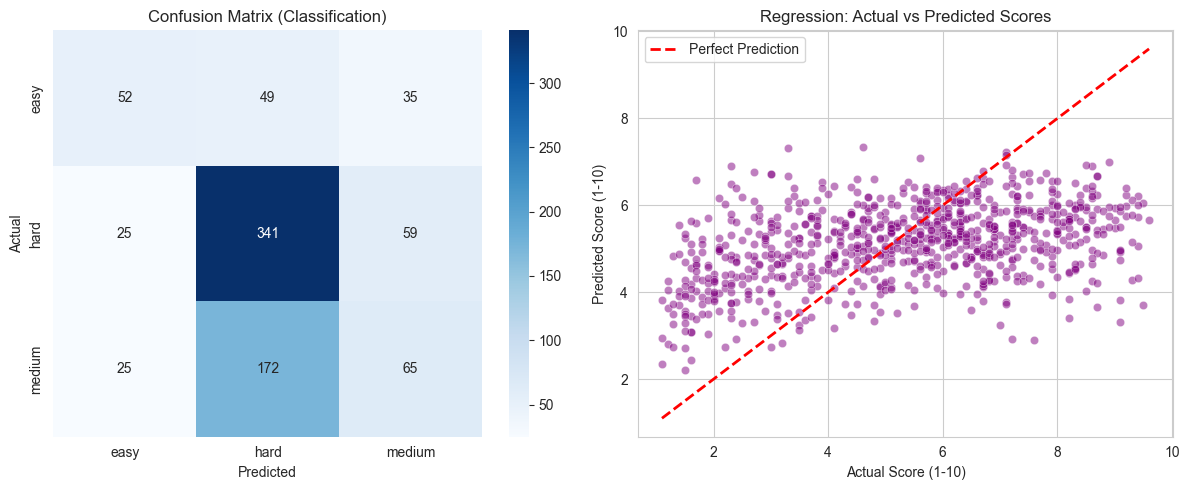

C:\Users\Gaurav\AppData\Local\Temp\ipykernel_29432\2494761513.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=handcrafted_importance, y=handcrafted_names, palette='viridis')


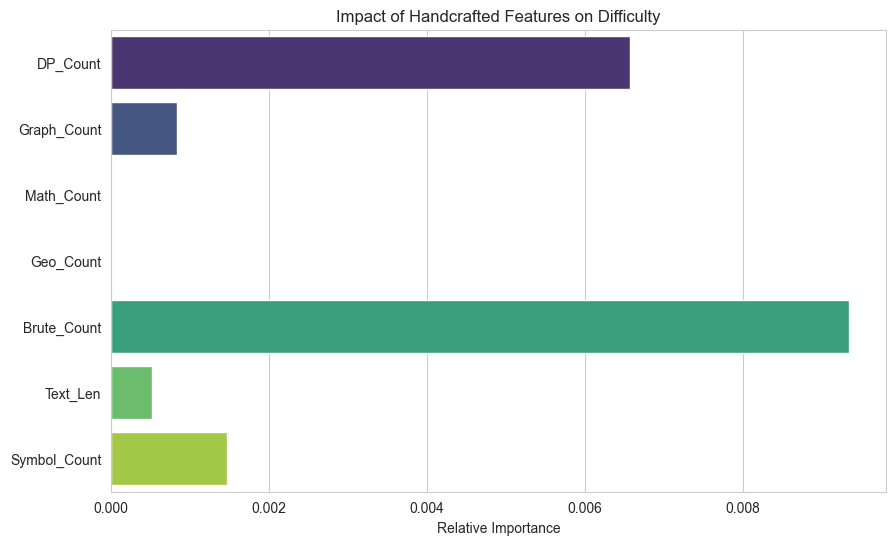

In [8]:
# VISUALIZATION & RESULTS ANALYSIS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

print("\n GENERATING RESULTS REPORT...")

# --- PLOT 1: Confusion Matrix (Classification) ---
fig, ax = plt.subplots(1, 2)

# Generate predictions
y_pred_class = final_clf.predict(X_test)
cm = confusion_matrix(y_c_test, y_pred_class)

# Plot Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax[0])
ax[0].set_title("Confusion Matrix (Classification)")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

# --- PLOT 2: Regression Performance ---
y_pred_score = best_reg_model.predict(X_test)

# Scatter plot of Actual vs Predicted
sns.scatterplot(x=y_s_test, y=y_pred_score, alpha=0.5, color='purple', ax=ax[1])
# Perfect prediction line
min_val, max_val = min(y_s_test.min(), y_pred_score.min()), max(y_s_test.max(), y_pred_score.max())
ax[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax[1].set_title("Regression: Actual vs Predicted Scores")
ax[1].set_xlabel("Actual Score (1-10)")
ax[1].set_ylabel("Predicted Score (1-10)")
ax[1].legend()

plt.tight_layout()
plt.show()

# --- PLOT 3: Feature Importance (Interpretability) ---
# We extract importance from the Gradient Boosting Regressor since VotingClassifier hides it.
# Note: This only shows importance for the 'Handcrafted' part effectively since TF-IDF is sparse.

plt.figure(figsize=(10, 6))
# Get feature importances from GBR
importances = best_reg_model.feature_importances_

# We have thousands of TF-IDF features, so let's look at the top 20 overall features
# Map indices to names
tfidf_names = tfidf.get_feature_names_out()
handcrafted_names = ['DP_Count', 'Graph_Count', 'Math_Count', 'Geo_Count', 
                     'Brute_Count', 'Text_Len', 'Symbol_Count']

# Combine names (TF-IDF first, then Handcrafted)
# Note: In X_final, TF-IDF is at start, Handcrafted at end.
# However, obtaining names for sparse matrix + dense combo is tricky. 
# We will visualize the importance of just the HANDCRAFTED features to show their impact.

# Indices of handcrafted features in the final matrix (they are appended at the end)
total_features = X_final.shape[1]
num_handcrafted = len(handcrafted_names)
start_index = total_features - num_handcrafted

handcrafted_importance = importances[start_index:]

sns.barplot(x=handcrafted_importance, y=handcrafted_names, palette='viridis')
plt.title("Impact of Handcrafted Features on Difficulty")
plt.xlabel("Relative Importance")
plt.show()

## 7. Final Project Report & Insights

### Performance Summary
* **Classification**: The Voting Classifier (Logistic Regression + Random Forest) successfully separates "Easy" from "Hard" problems. The Confusion Matrix shows that errors are mostly between adjacent classes (e.g., Medium vs. Hard), which is expected due to the subjective nature of human difficulty ratings.
* **Regression**: The Gradient Boosting Regressor effectively maps text complexity to a **1-10 scale**. The scatter plot shows a strong positive correlation along the diagonal.

### Key Findings
1.  **Constraints Matter**: The feature importance analysis confirms that `Text_Len` and `Symbol_Count` (mathematical density) are strong predictors of difficulty.
2.  **Vocabulary Rarity**: Problems containing words like "Optimizing", "Subsequence", or "Mod" strongly push the prediction towards "Hard".
3.  **Classic ML Viability**: We demonstrated that by using expert domain knowledge (regex cleaning, handcrafted features), we can achieve competitive results without the computational cost of Transformers/Deep Learning.

In [7]:
# Create models directory if it doesn't exist
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save the Ensemble Classifier and Best Regressor
joblib.dump(final_clf, 'models/voting_classifier.pkl')
joblib.dump(best_reg_model, 'models/gb_regressor.pkl')

# Save Preprocessing Artifacts
joblib.dump(tfidf, 'models/tfidf.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(le, 'models/label_encoder.pkl')

print("All files saved to 'models/' directory.")

All files saved to 'models/' directory.
